## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

from collections import defaultdict
import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [3]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [4]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.cache)
importlib.reload(market_data.ingest.bq.candle)

<module 'market_data.ingest.bq.candle' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/candle.py'>

In [5]:
date_str_from='2024-03-01'
date_str_to='2024-03-03'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [6]:
import market_data.ingest.bq.cache

df = market_data.ingest.bq.cache.read_from_cache(
    label = 'market_data',
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, 
    date_str_to=date_str_to)
df_close = df.reset_index().pivot(index='timestamp', columns='symbol', values='close')
dfi = df.reset_index().set_index(['timestamp', 'symbol'])

In [7]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

173

## calculate/cache features

In [8]:
import algo.alpha.jitter_recovery.calculate
importlib.reload(algo.alpha.jitter_recovery.calculate)
import algo.feature.collective_jitter.calculate
importlib.reload(algo.feature.collective_jitter.calculate)
import algo.alpha.collective_jitter_recovery.calculate
importlib.reload(algo.alpha.collective_jitter_recovery.calculate)
import algo.feature.jitter.research
importlib.reload(algo.feature.jitter.research)
import algo.feature.collective_jitter.research
importlib.reload(algo.feature.collective_jitter.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [9]:
feature_param = algo.feature.collective_jitter.calculate.CollectiveJitterFeatureParam(window=40, collective_window=30)

In [10]:
algo.feature.collective_jitter.research.get_feature_label_for_caching(feature_param)

'feature/(collectivechanges)_window(40)_collective_window(30)'

In [11]:
# dfst_feature = algo.feature.collective_jitter.research.get_dfst_feature(df, feature_param)

In [12]:
dfst_feature = market_data.ingest.bq.cache.read_from_cache(
    label = algo.feature.collective_jitter.research.get_feature_label_for_caching(feature_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-11-22', 
    date_str_to='2024-11-23')

In [13]:
dfst_feature[['ch']].dropna()

,,ch
symbol,timestamp,
EOS-USDT-SWAP,2024-11-22 00:00:00-05:00,-0.000578
AXS-USDT-SWAP,2024-11-22 00:00:00-05:00,0.004957
NEIROETH-USDT-SWAP,2024-11-22 00:00:00-05:00,-0.003355
MASK-USDT-SWAP,2024-11-22 00:00:00-05:00,0.001332
FOXY-USDT-SWAP,2024-11-22 00:00:00-05:00,-0.002985
...,...,...
CSPR-USDT-SWAP,2024-11-22 23:59:00-05:00,0.004764
GFT-USDT-SWAP,2024-11-22 23:59:00-05:00,0.010284
LQTY-USDT-SWAP,2024-11-22 23:59:00-05:00,0.009744


## multiple symbols

In [14]:
import algo.alpha.jitter_recovery.calculate
importlib.reload(algo.alpha.jitter_recovery.calculate)
import algo.feature.collective_jitter.calculate
importlib.reload(algo.feature.collective_jitter.calculate)
import algo.alpha.collective_jitter_recovery.calculate
importlib.reload(algo.alpha.collective_jitter_recovery.calculate)
import algo.feature.jitter.research
importlib.reload(algo.feature.jitter.research)
import algo.feature.collective_jitter.research
importlib.reload(algo.feature.collective_jitter.research)
import algo.alpha.collective_jitter_recovery.research
importlib.reload(algo.alpha.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [15]:
trading_param = algo.alpha.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.alpha.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)

In [16]:
algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param)

'trading/(collectivechanges_trading)_feature_param(window(40)_collective_window(30))_collective_drop_recovery_trading_param(collective_drop_threshold(-0.03)_collective_drop_lower_threshold(-0.3)_drop_threshold(-0.03)_jump_from_drop_threshold(0.005)/exit_drop_threshold(-0.01))_collective_jump_recovery_trading_param(None)'

In [17]:
#dfst_trading = algo.alpha.collective_jitter_recovery.research.get_dfst_trading(dfst_feature, trading_param)
#dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

2024-12-09 22:02:57,202 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(collectivechanges_trading)_feature_param(window(40)_collective_window(30))_collective_drop_recovery_trading_param(collective_drop_threshold(-0.03)_collective_drop_lower_threshold(-0.3)_drop_threshold(-0.03)_jump_from_drop_threshold(0.005)/exit_drop_threshold(-0.01))_collective_jump_recovery_trading_param(None)/trading-290017.market_data_okx.by_minute_take_tatest/2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet' does not exist in local cache. For gcs, blob_exist=False.


<AxesSubplot:xlabel='timestamp'>

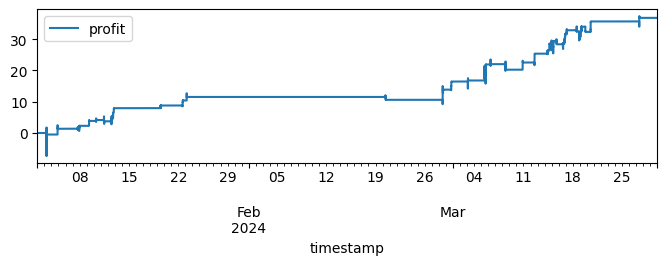

In [54]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-01-01', 
    date_str_to='2024-03-30',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

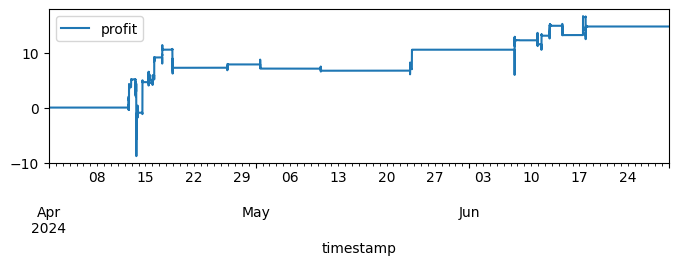

In [18]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-04-01', 
    date_str_to='2024-06-30',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

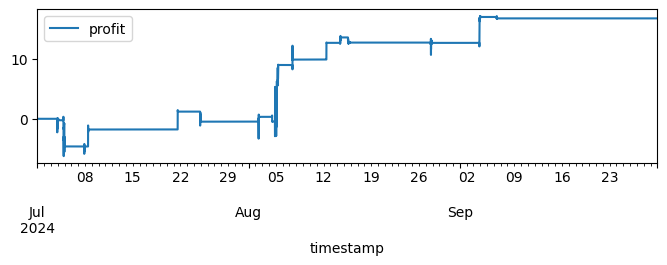

In [20]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-07-01', 
    date_str_to='2024-09-30',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

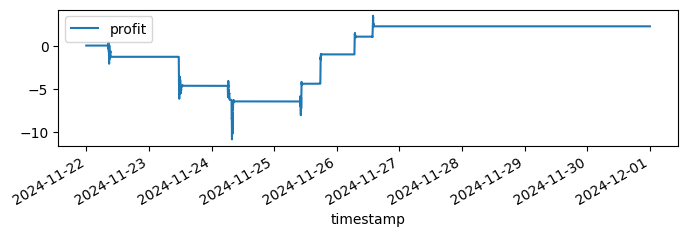

In [25]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-11-22', 
    date_str_to='2024-12-01',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

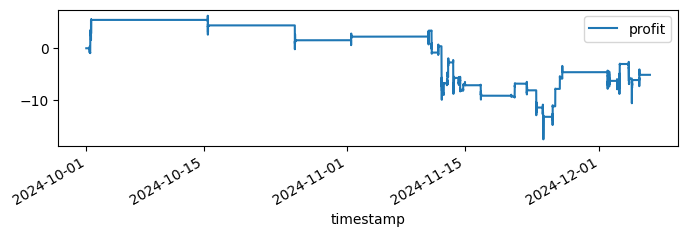

In [21]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-10-01', 
    date_str_to='2024-12-07',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

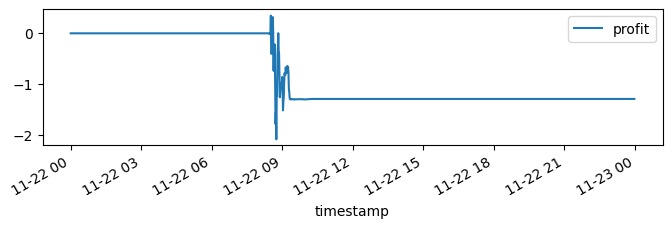

In [30]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-11-22', 
    date_str_to='2024-11-23',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [32]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit')

,profit
symbol,
CTC-USDT-SWAP,-0.030424
WLD-USDT-SWAP,-0.030217
ZENT-USDT-SWAP,-0.029946
DOG-USDT-SWAP,-0.029089
STX-USDT-SWAP,-0.027305
...,...
GRASS-USDT-SWAP,0.012934
DEGEN-USDT-SWAP,0.013449
MOODENG-USDT-SWAP,0.015084


In [33]:
len(dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit'))

186

<AxesSubplot:xlabel='timestamp'>

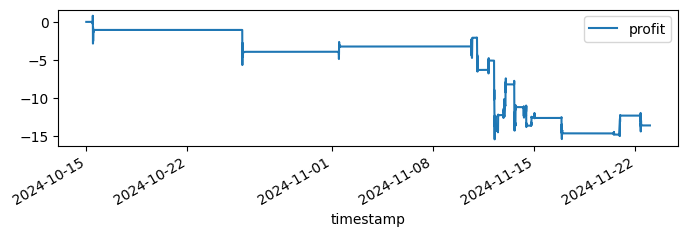

In [34]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-10-15', 
    date_str_to='2024-11-23',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [39]:
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

<AxesSubplot:xlabel='timestamp'>

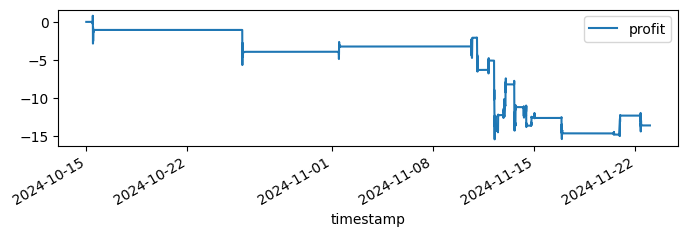

In [40]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-10-15', 
    date_str_to='2024-11-23',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

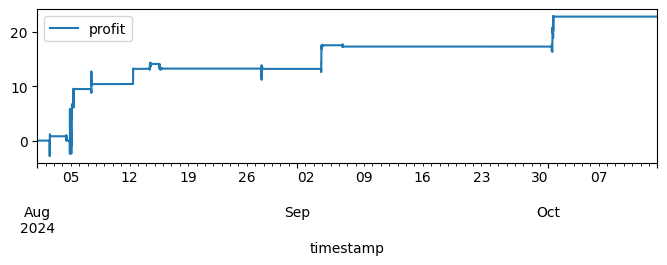

In [41]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-08-01', 
    date_str_to='2024-10-14',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

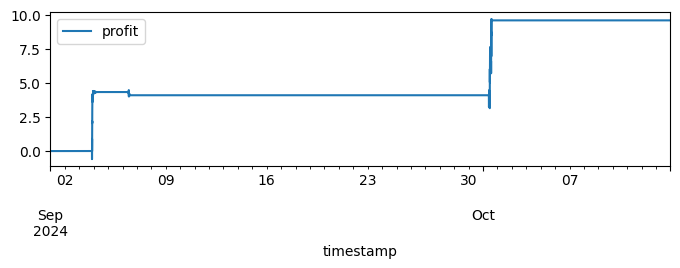

In [42]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-09-01', 
    date_str_to='2024-10-14',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

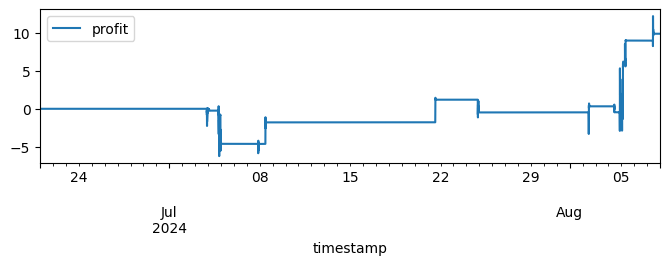

In [43]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-06-21', 
    date_str_to='2024-08-08',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

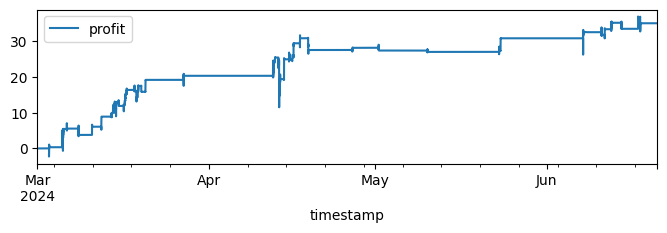

In [44]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-03-01', 
    date_str_to='2024-06-21',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

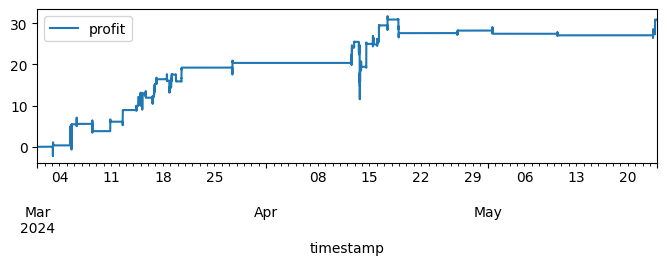

In [45]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-03-01', 
    date_str_to='2024-05-24',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

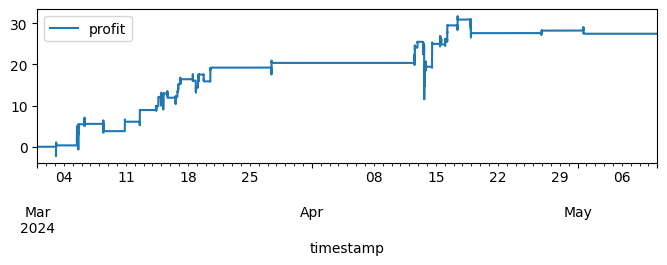

In [46]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-03-01', 
    date_str_to='2024-05-10',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

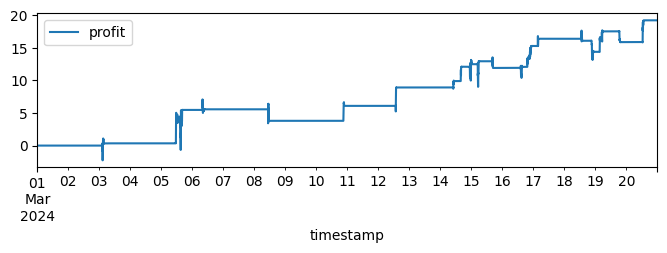

In [47]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-03-01', 
    date_str_to='2024-03-21',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

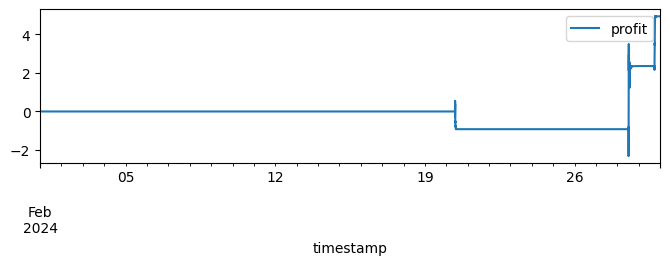

In [54]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-02-01', 
    date_str_to='2024-03-01',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

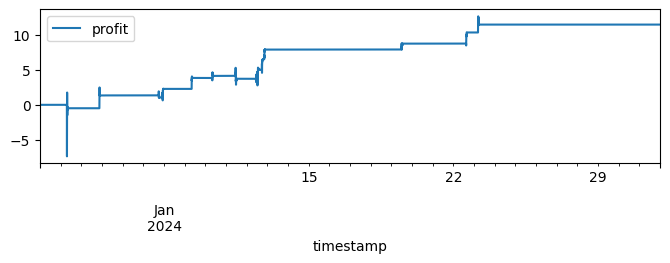

In [53]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-01-02', 
    date_str_to='2024-02-01',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<AxesSubplot:xlabel='timestamp'>

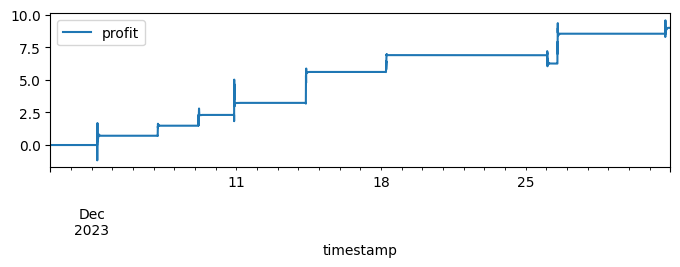

In [52]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2023-12-02', 
    date_str_to='2024-01-01',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [18]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2023-12-02', 
    date_str_to='2024-01-01')

2024-04-02 15:15:47,578 [MainThread  ] [INFO ]  filename='/home/junlim/feature_data/(collectivechanges_trading)_feature_param(window(40)_collective_window(30))_collective_drop_recovery_trading_param(collective_drop_threshold(-0.03)_collective_drop_lower_threshold(-0.3)_drop_threshold(-0.03)_jump_from_drop_threshold(0.005)/exit_drop_threshold(-0.01))_collective_jump_recovery_trading_param(None)/trading-290017.market_data_okx.by_minute_2023-12-01T00:00:00-0500_2023-12-02T00:00:00-0500.parquet' does not exist.
2024-04-02 15:15:47,579 [MainThread  ] [INFO ]  df_cache is None for (datetime.datetime(2023, 12, 1, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>), datetime.datetime(2023, 12, 2, 0, 0, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>))


<Axes: xlabel='timestamp'>

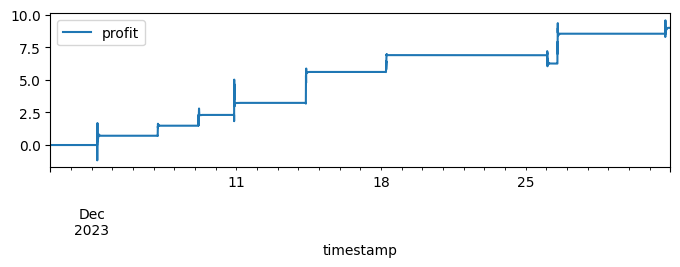

In [19]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

2024-12-09 21:43:28,422 [MainThread  ] [INFO ]  filename='/Users/junlim/algo_cache/trading/(collectivechanges_trading)_feature_param(window(40)_collective_window(30))_collective_drop_recovery_trading_param(collective_drop_threshold(-0.03)_collective_drop_lower_threshold(-0.3)_drop_threshold(-0.03)_jump_from_drop_threshold(0.005)/exit_drop_threshold(-0.01))_collective_jump_recovery_trading_param(None)/trading-290017.market_data_okx.by_minute_take_tatest/2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet' does not exist in local cache. For gcs, blob_exist=False.


<AxesSubplot:xlabel='timestamp'>

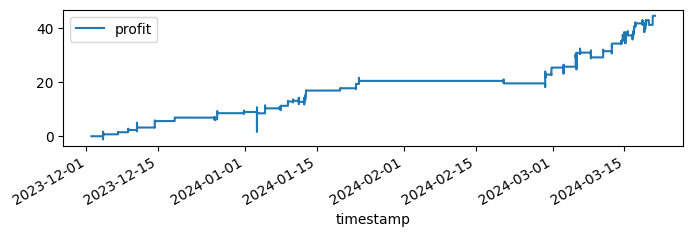

In [51]:
dfst_trading = market_data.ingest.bq.cache.read_from_cache(
    label = algo.alpha.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode = dataset_mode,
    export_mode = export_mode,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2023-12-02', 
    date_str_to='2024-03-21',
    columns=['profit', 'value', 'position_changed'],
)
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [56]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if 'PERP' not in row['symbol']: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-02-20 09:43:00-05:00, PERP-USDT-SWAP, 1.3681, position_changed: 1.0
2024-02-20 10:05:00-05:00, PERP-USDT-SWAP, 1.3595, position_changed: -1.0
2024-02-20 10:08:00-05:00, PERP-USDT-SWAP, 1.3698, position_changed: 1.0
2024-02-20 10:17:00-05:00, PERP-USDT-SWAP, 1.3546, position_changed: -1.0
2024-02-28 12:35:00-05:00, PERP-USDT-SWAP, 1.2787, position_changed: 1.0
2024-02-28 12:37:00-05:00, PERP-USDT-SWAP, 1.253, position_changed: -1.0
2024-02-28 12:38:00-05:00, PERP-USDT-SWAP, 1.2522, position_changed: 1.0
2024-02-28 12:46:00-05:00, PERP-USDT-SWAP, 1.2782, position_changed: -1.0
2024-02-28 12:47:00-05:00, PERP-USDT-SWAP, 1.2878, position_changed: 1.0
2024-02-28 12:58:00-05:00, PERP-USDT-SWAP, 1.2996, position_changed: -1.0
2024-02-28 13:31:00-05:00, PERP-USDT-SWAP, 1.2884, position_changed: 1.0
2024-02-28 13:44:00-05:00, PERP-USDT-SWAP, 1.2738, position_changed: -1.0
2024-02-29 17:41:00-05:00, PERP-USDT-SWAP, 1.272, position_changed: 1.0
2024-02-29 18:11:00-05:00, PERP-USDT-SWAP, 1.29

In [58]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')
    break

2024-02-20 09:43:00-05:00, RSR-USDT-SWAP, 0.00282, position_changed: 1.0


## single symobl

In [60]:
import algo.alpha.jitter_recovery.calculate
importlib.reload(algo.alpha.jitter_recovery.calculate)
import algo.alpha.collective_jitter_recovery.calculate
importlib.reload(algo.alpha.collective_jitter_recovery.calculate)
import algo.alpha.jitter_recovery.research
importlib.reload(algo.alpha.jitter_recovery.research)
import algo.alpha.collective_jitter_recovery.research
importlib.reload(algo.alpha.collective_jitter_recovery.research)

<module 'algo.alpha.collective_jitter_recovery.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/collective_jitter_recovery/research.py'>

In [61]:
symbol_investigate = 'PEPE-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [63]:
df_feature, df_trading = algo.alpha.collective_jitter_recovery.research.investigate_symbol(df, df_collective_feature, symbol_investigate, trading_param, figsize=(8, 11))

NameError: name 'df_collective_feature' is not defined

<Axes: xlabel='timestamp'>

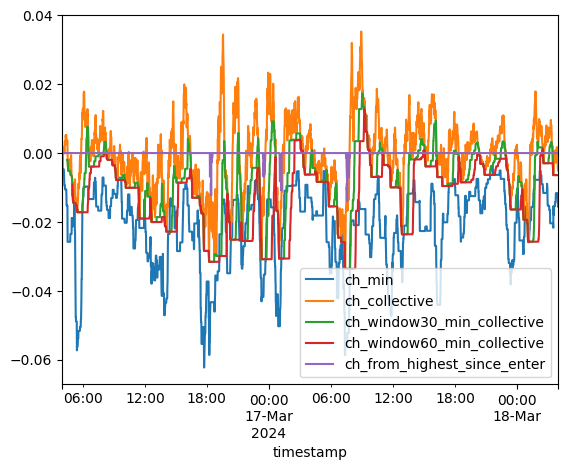

In [45]:
df_trading[['ch_min', 'ch_collective', 'ch_window30_min_collective', 'ch_window60_min_collective', 'ch_from_highest_since_enter']].plot()

In [577]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:13:00,0.000265,1,1.0,0.000000,0.000000
2024-01-03 12:16:00,0.000258,0,-1.0,-0.000014,-0.052225
2024-01-03 12:17:00,0.000275,1,1.0,0.000000,0.000000
2024-01-03 12:19:00,0.000269,0,-1.0,-0.000015,-0.053502
2024-01-03 12:20:00,0.000279,1,1.0,0.000000,0.000000
2024-01-03 12:26:00,0.000283,0,-1.0,0.000008,0.029080
2024-01-03 12:27:00,0.000278,1,1.0,-0.000000,-0.000000
2024-01-03 12:32:00,0.000286,0,-1.0,-0.000004,-0.012440


In [578]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:13:00, TURBO-USDT-SWAP, 0.0002649, position_changed: 1.0
2024-01-03 12:16:00, TURBO-USDT-SWAP, 0.0002577, position_changed: -1.0
2024-01-03 12:17:00, TURBO-USDT-SWAP, 0.0002746, position_changed: 1.0
2024-01-03 12:19:00, TURBO-USDT-SWAP, 0.0002689, position_changed: -1.0
2024-01-03 12:20:00, TURBO-USDT-SWAP, 0.0002791, position_changed: 1.0
2024-01-03 12:26:00, TURBO-USDT-SWAP, 0.0002831, position_changed: -1.0
2024-01-03 12:27:00, TURBO-USDT-SWAP, 0.0002781, position_changed: 1.0
2024-01-03 12:32:00, TURBO-USDT-SWAP, 0.0002858, position_changed: -1.0
